In [1]:
from pathlib import Path  # optional, for nice path specifications

import pprint as pp

import numpy as np
import matplotlib.pyplot as plt

import openmdao.api as om

from ard.utils.io import load_yaml
from ard.api import set_up_ard_model
from ard.viz.layout import plot_layout

%matplotlib inline

numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject

In [2]:
# load input
mod = True
path_inputs = Path.cwd().absolute() / "inputs"
input_dict = load_yaml(path_inputs / f"ard_system{"_mod" if mod else ""}.yaml")

# set up system
prob = set_up_ard_model(input_dict=input_dict, root_data_path=path_inputs)

Adding top_level
Adding aepFLOWERS
Adding aepFLORIS
Adding collection
Adding mooring_design
Adding mooring_constraint
Adding spacing_constraint
Adding boundary
Adding anchor_boundary
Adding tcc
Adding orbit
Adding bos_combiner
Adding opex
Adding financese
	Activating approximate totals on top_level
Creating MoorPy Array
No hydrostatics information given, so default body hydrostatics from UMaine VolturnUS-S will be used.


In [3]:
# necessary for full-farm optimization right now...

prob.model.set_input_defaults(
    "x_turbines",
    input_dict["modeling_options"]["windIO_plant"]["wind_farm"]["layouts"][
        "coordinates"
    ]["x"],
    units="m",
)
prob.model.set_input_defaults(
    "y_turbines",
    input_dict["modeling_options"]["windIO_plant"]["wind_farm"]["layouts"][
        "coordinates"
    ]["y"],
    units="m",
)
prob.model.set_input_defaults(
    "phi_platform",
    input_dict["modeling_options"]["layout"]["phi_platform"]
    * np.ones_like(
        input_dict["modeling_options"]["windIO_plant"]["wind_farm"]["layouts"][
            "coordinates"
        ]["y"]
    ),
    units="deg",
)

/Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/openmdao/core/group.py:368: PromotionWarning:<model> <class Group>: Setting input defaults for input 'x_turbines' which override previously set defaults for ['auto', 'prom', 'units'].
/Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/openmdao/core/group.py:368: PromotionWarning:<model> <class Group>: Setting input defaults for input 'y_turbines' which override previously set defaults for ['auto', 'prom', 'units'].


In [4]:
# visualize model
if True:
    om.n2(prob)

In [5]:
# run the model
prob.run_model()

# BEGIN DEBUG!!!!!
print(prob.get_val("collection.terse_links"))
# END DEBUG!!!!!

# collapse the test result data
test_data = {
    "AEP_val": float(prob.get_val("AEP_farm", units="GW*h")[0]),
    "AEP_FLORIS": float(prob.get_val("AEP_FLORIS", units="GW*h")[0]),
    "CapEx_val": float(prob.get_val("tcc.tcc", units="MUSD")[0]),
    "BOS_val": float(prob.get_val("orbit.total_capex", units="MUSD")[0]),
    "OpEx_val": float(prob.get_val("opex.opex", units="MUSD/yr")[0]),
    "LCOE_val": float(prob.get_val("financese.lcoe", units="USD/MW/h")[0]),
    # "area_tight": float(prob.get_val("landuse.area_tight", units="km**2")[0]),
    "coll_length": float(prob.get_val("collection.total_length_cables", units="km")[0]),
    "mooring_spacing": float(
        np.min(prob.get_val("mooring_constraint.mooring_spacing", units="km"))
    ),
    "turbine_spacing": float(
        np.min(prob.get_val("spacing_constraint.turbine_spacing", units="km"))
    ),
}

print("\n\nRESULTS:\n")
pp.pprint(test_data)
print("\n\n")

/Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/openmdao/recorders/sqlite_recorder.py:231: UserWarning:The existing case recorder file, ard_prob_out/problem_out/opt_results.sql, is being overwritten.
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

ORBIT library intialized at '/Users/cfrontin/codes/Ard/examples/04_offshore_floating_detailed_mooring/case_files/working/ORBIT_library'
[ 1.  6.  7.  2.  9. -1. -1. -1. -1.  8.]


RESULTS:

{'AEP_FLORIS': 755.5328986317994,
 'AEP_val': 779.1503469769347,
 'BOS_val': 764.7172655031263,
 'CapEx_val': 209.5755701025,
 'LCOE_val': 114.98018371891072,
 'OpEx_val': 16.500000000000004,
 'coll_length': 15.43149232206507,
 'mooring_spacing': 0.03646582241311728,
 'turbine_spacing': 1.25}





Missing data in columns ['cable_length', 'bury_speed']; all values will be calculated.DeprecationWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

In [ ]:
optimize = False  # set to False to skip optimization
rerun_optimize = True  # set to False to load from the last one...
if optimize and rerun_optimize:
    # run the optimization
    prob.run_driver()
    prob.cleanup()

    # collapse the test result data
    test_data = {
        "x_turbines": prob.get_val("x_turbines", units="km"),
        "y_turbines": prob.get_val("y_turbines", units="km"),
        # "spacing_primary": float(prob.get_val("spacing_primary")[0]),
        # "spacing_secondary": float(prob.get_val("spacing_secondary")[0]),
        # "angle_orientation": float(prob.get_val("angle_orientation")[0]),
        # "angle_skew": float(prob.get_val("angle_skew")[0]),
        "AEP_val": float(prob.get_val("AEP_farm", units="GW*h")[0]),
        "AEP_FLORIS": float(prob.get_val("AEP_FLORIS", units="GW*h")[0]),
        "CapEx_val": float(prob.get_val("tcc.tcc", units="MUSD")[0]),
        "BOS_val": float(prob.get_val("orbit.total_capex", units="MUSD")[0]),
        "OpEx_val": float(prob.get_val("opex.opex", units="MUSD/yr")[0]),
        "LCOE_val": float(prob.get_val("financese.lcoe", units="USD/MW/h")[0]),
        # "area_tight": float(prob.get_val("landuse.area_tight", units="km**2")[0]),
        "coll_length": float(
            prob.get_val("collection.total_length_cables", units="km")[0]
        ),
        "mooring_spacing": float(
            np.min(prob.get_val("mooring_constraint.mooring_spacing", units="km"))
        ),
        "turbine_spacing": float(
            np.min(prob.get_val("spacing_constraint.turbine_spacing", units="km"))
        ),
    }

    # clean up the recorder
    prob.cleanup()
elif optimize:
    pass

    # print the results
    print("\n\nRESULTS (opt):\n")
    pp.pprint(test_data)
    print("\n\n")

invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divideUserWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['cable_length', 'bury_speed']; all values will be calculated.DeprecationWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.RuntimeWar

Iteration limit reached    (Exit mode 9)
            Current function value: 1.0670286656028114
            Iterations: 35
            Function evaluations: 60
            Gradient evaluations: 36
Optimization FAILED.
Iteration limit reached
-----------------------------------


In [7]:
if optimize:
    # plot convergence
    ## read cases
    cr = om.CaseReader(
        prob.get_outputs_dir() / input_dict["analysis_options"]["recorder"]["filepath"]
    )

    # Extract the driver cases
    cases = cr.get_cases("driver")

    # Initialize lists to store iteration data
    iterations = []
    objective_values = []

    # Loop through the cases and extract iteration number and objective value
    for i, case in enumerate(cases):
        iterations.append(i)
        objective_values.append(
            case.get_objectives()[input_dict["analysis_options"]["objective"]["name"]]
        )

FigureCanvasAgg is non-interactive, and thus cannot be shown

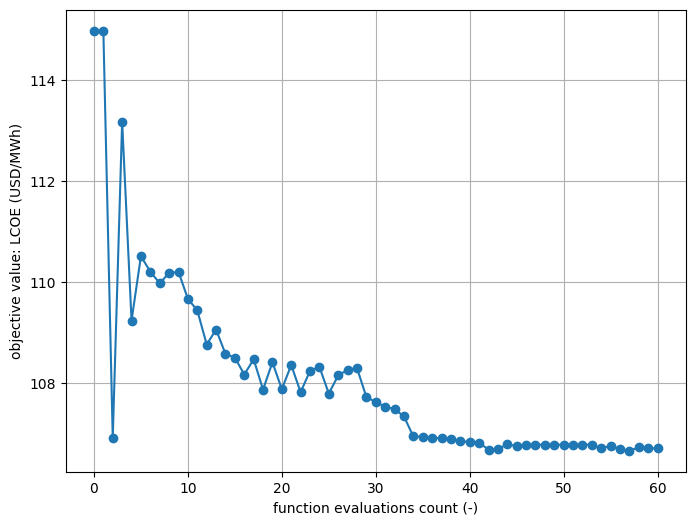

In [8]:
if optimize:
    # Plot the convergence
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(
        iterations,
        np.array(objective_values)
        / input_dict["analysis_options"]["objective"]
        .get("options", {})
        .get("scaler", 1.0),
        marker="o",
        label=f"objective ({input_dict['analysis_options']['objective'].get('name')})",
    )
    ax.set_xlabel("Iteration number (-)")
    ax.set_ylabel(
        f"Objective value ({input_dict['analysis_options']['objective'].get('name')})"
    )
    # ax.legend()
    ax.grid()
    ax.set_xlabel("function evaluations count (-)")
    ax.set_ylabel("objective value: LCOE (USD/MWh)")

    fig.savefig(
        Path.cwd().absolute()
        / "img"
        / (
            f"convergence_{input_dict['analysis_options']['driver']['name']}"
            f"_{input_dict['analysis_options']['driver']['options']['optimizer']}.png"
        ),
        dpi=300,
        bbox_inches="tight",
    )
    fig.show()

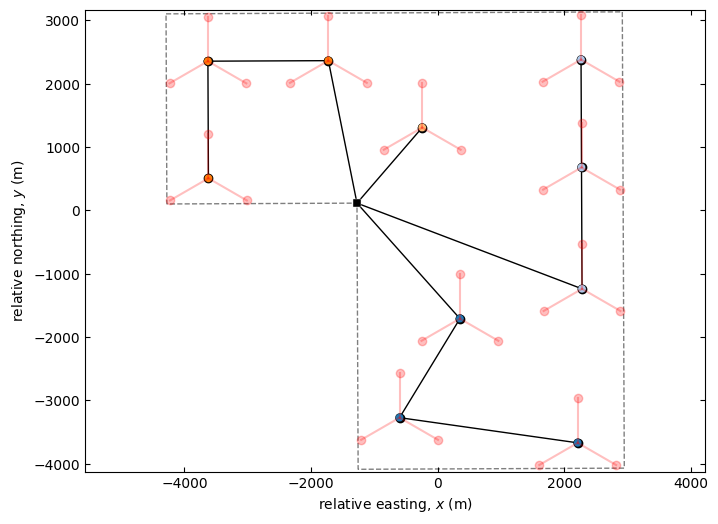

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
ax = plot_layout(
    prob,
    input_dict=input_dict,
    # show_image=True,
    # include_cable_routing=False,
    include_cable_routing=True,
    include_mooring_system=True,
    ax=ax,
)
ax.tick_params(
    axis="both",
    which="both",
    direction="in",
    top=True,
    right=True,
    bottom=True,
    left=True,
    labelbottom=True,
    labelleft=True,
)

ax.set_xlabel("relative easting, $x$ (m)")
ax.set_ylabel("relative northing, $y$ (m)")

fig.savefig(
    Path.cwd().absolute()
    / "img"
    / (
        f"layout_result_{input_dict['analysis_options']['driver']['name']}"
        f"_{input_dict['analysis_options']['driver']['options']['optimizer']}.png"
    ),
    dpi=300,
    bbox_inches="tight",
)

In [10]:
comp_data_COBYLA = np.array(
    [
        [2.22, 2.36, 0.0],
        [2.27, 0.44, 0.0],
        [2.29, -3.48, 0.0],
        [-0.07, 1.97, 0.0],
        [-2.42, 1.34, 0.0],
        [-0.46, -1.61, 0.0],
        [-0.29, -0.05, 0.0],
        [2.20, -1.66, 0.0],
        [-3.63, 2.20, 0.0],
        [-0.57, -3.64, 0.0],
    ]
)

comp_data_SLSQP = [
    [-3.63, 2.22, 0.0],
    [-0.61, 2.10, 0.0],
    [2.06, 1.50, 0.0],
    [-0.03, -0.44, 0.0],
    [-0.56, -3.60, 0.0],
    [1.90, -3.55, 0.0],
    [-2.55, 1.24, 0.0],
    [0.85, 2.01, 0.0],
    [-0.37, -1.73, 0.0],
    [1.91, -1.59, 0.0],
]

In [11]:
# prob.model.financese.list_vars()

In [12]:
# prob.model.orbit.list_vars()